In [6]:
%run setup.py

In [2]:
df = pd.read_csv('../../../../Dropbox (Sydney Uni)/Shared/pulsator_fraction/all_stars_with_gaia_mathur_green.csv')
puls = df[df['pulsating']==1]

Let's count the number of TESS CVZ stars with 2 min data

In [6]:
files = []
import glob

for sector in list(range(1,14)):
    files.extend(glob.glob('/Volumes/silo2/dhey3294/TESS/sector_' + str(sector) + '/tess*.fits'))

tics = [a.split('_')[1].split('/')[-1].split('-')[2].lstrip('0') for a in files]
unique_tics = np.unique(tics)

In [7]:
df = pd.read_csv('../data/MAST_Crossmatch_TIC.csv', skiprows=4)
cut = (df['Teff'] > 6500) & (df['Teff'] < 10000)

unique_tics = df[cut]['target_name'].values

And now search for delta Scuti stars

In [8]:
from scipy.stats import skew

def dsct_search(unique_tic):
    try:
        unique_tic = str(unique_tic)
        indices = [i for i, x in enumerate(tics) if x == unique_tic]

        lc = lk.TessLightCurveFile(files[indices[0]]).PDCSAP_FLUX.normalize()
        for index in indices[1:]:
            lc = lc.append(lk.TessLightCurveFile(files[index]).PDCSAP_FLUX.normalize())
    except:
        return None
    lc = lc.remove_nans()
    pg = lc.to_periodogram(normalization='amplitude')#.plot()
    skewer = skew(pg.power.value[(pg.frequency.value > 20) & (pg.frequency.value < 100)])
    if skewer > 5:
        fig, axes = plt.subplots(3,1, figsize=[8,13])
        lc.plot(ax=axes[0])
        axes[1].plot(pg.frequency.value, pg.power.value, linewidth=0.7)
        axes[2].plot(pg.frequency.value, pg.power.value, linewidth=0.7)
        axes[2].set_xlim(0,100)
        plt.savefig('dSct search/' + unique_tic + '.png', bbox_inches='tight')
        plt.clf()
        plt.close(fig)
        return unique_tic, skewer, pg.power.value.max() / np.median(pg.power.value)
    else:
        return None

In [9]:
from tqdm import tqdm

dscts = []
for unique_tic in tqdm(unique_tics):
    dscts.append(dsct_search(unique_tic))

100%|██████████| 1651/1651 [00:00<00:00, 273610.02it/s]


(0, 1750)

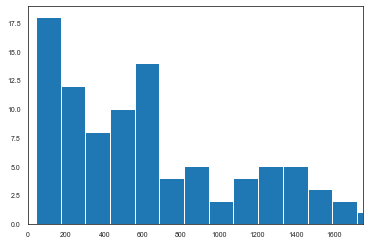

In [4]:
res = np.loadtxt('res.txt')

snrs = np.array(np.array(res)[:,2], dtype=float)
plt.hist(snrs[snrs<2000], bins=15);
plt.xlim(0,1750)

In [11]:
import matplotlib
matplotlib.rcParams["font.size"] = 7

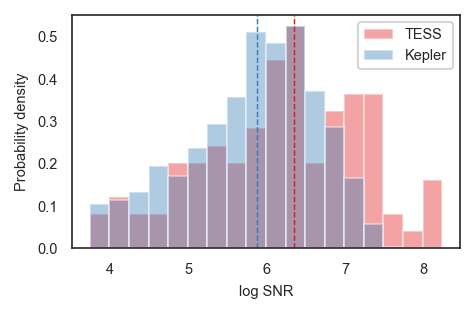

In [12]:
import seaborn as sns
sns.set_style('white')

plt.figure(figsize=mnras_size(240.))

_, bins, _ = plt.hist(np.log(snrs), bins=18, alpha=0.4, density=True, color=red, label=r'TESS');
plt.hist(np.log(puls['snrmed']), bins=bins, alpha=0.4, color=blue, density=True, label=r'Kepler')
plt.xlabel('log SNR')
plt.ylabel('Probability density')
plt.legend()

plt.axvline(np.median(np.log(snrs)), c=red, linewidth=0.7, linestyle='dashed')
plt.axvline(np.median(np.log(puls['snrmed'])), c=blue, linewidth=0.7, linestyle='dashed')

plt.savefig(overleaf_path + 'dsct_tess_kepler_comparison.pdf', dpi=300, bbox_inches='tight', pad_inches=0)